In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import librosa
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Mount Google Drive for access
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# Load data from JSON files training with MFCC and overlap
with open('/content/drive/MyDrive/My-207/X_train_mfcc.json', 'r') as file:
    X_train_list = json.load(file)
    X_train = np.array(X_train_list)

with open('/content/drive/MyDrive/My-207/y_train_mfcc.json', 'r') as file:
    y_train_list = json.load(file)
    y_train = np.array(y_train_list)

# Load data from JSON files
with open('/content/drive/MyDrive/My-207/X_val_mfcc.json', 'r') as file:
    X_val_list = json.load(file)
    X_val = np.array(X_val_list)

with open('/content/drive/MyDrive/My-207/y_val_mfcc.json', 'r') as file:
    y_val_list = json.load(file)
    y_val = np.array(y_val_list)



In [3]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Save the label encoder for later use
label_encoder_path = "label_encoder.pkl"
import joblib
joblib.dump(label_encoder, label_encoder_path)

print(X_train.shape)
print(X_val.shape)


(7889, 20, 157)
(3121, 20, 157)


In [4]:
from sklearn.preprocessing import MinMaxScaler

train_X_reshape = X_train.reshape(-1, 20*157)
val_X_reshape = X_val.reshape(-1, 20*157)

scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

train_X_scaled = scaler.transform(train_X_reshape)
val_X_scaled = scaler.transform(val_X_reshape)

X_train = train_X_scaled.reshape(-1,20,157)
X_val = val_X_scaled.reshape(-1,20,157)

print(X_train.shape)
print(X_val.shape)



(7889, 20, 157)
(3121, 20, 157)


In [5]:
# swap the x and y axis so doing convolution on the time dimension
train_X_perm = []
for each in X_train:
  train_X_perm.append(np.transpose(each))

X_train = np.array(train_X_perm)

val_X_perm = []
for each in X_val:
  val_X_perm.append(np.transpose(each))

X_val = np.array(val_X_perm)

print(X_train.shape)
print(X_val.shape)

(7889, 157, 20)
(3121, 157, 20)


In [6]:
from sklearn.utils import shuffle
train_X, train_y = shuffle(X_train, y_train, random_state=1234)
val_X, val_y = shuffle(X_val, y_val, random_state=1234)

In [7]:
# Build CNN model topology
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [8]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 155, 18, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 77, 9, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 7, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 3, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7104)              0         
                                                                 
 dense (Dense)               (None, 128)               9

In [9]:


# Train the model
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), batch_size=32, epochs=20)

Epoch 1/20
247/247 [==============================] - 42s 167ms/step - loss: 0.9261 - accuracy: 0.5367 - val_loss: 0.9616 - val_accuracy: 0.5242
Epoch 2/20
247/247 [==============================] - 40s 164ms/step - loss: 0.5926 - accuracy: 0.7623 - val_loss: 0.6979 - val_accuracy: 0.7046
Epoch 3/20
247/247 [==============================] - 38s 153ms/step - loss: 0.4622 - accuracy: 0.8244 - val_loss: 0.7915 - val_accuracy: 0.7087
Epoch 4/20
247/247 [==============================] - 38s 154ms/step - loss: 0.3792 - accuracy: 0.8603 - val_loss: 0.6271 - val_accuracy: 0.7703
Epoch 5/20
247/247 [==============================] - 38s 153ms/step - loss: 0.3239 - accuracy: 0.8795 - val_loss: 0.5696 - val_accuracy: 0.7799
Epoch 6/20
247/247 [==============================] - 40s 162ms/step - loss: 0.2834 - accuracy: 0.8939 - val_loss: 0.6058 - val_accuracy: 0.7639
Epoch 7/20
247/247 [==============================] - 36s 144ms/step - loss: 0.2409 - accuracy: 0.9094 - val_loss: 0.6254 - val_ac

In [13]:
model.save('/content/drive/MyDrive/207/207-Project/notebooks/AA/CNN_MFCC.h5')

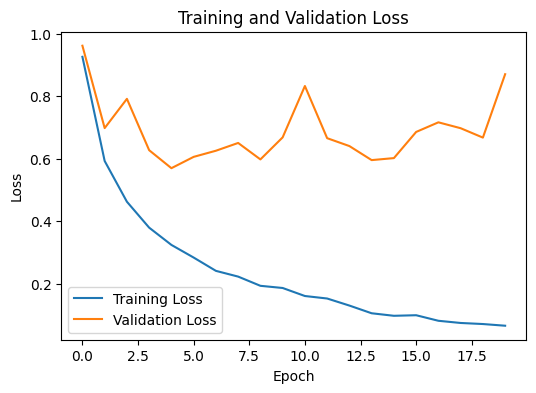

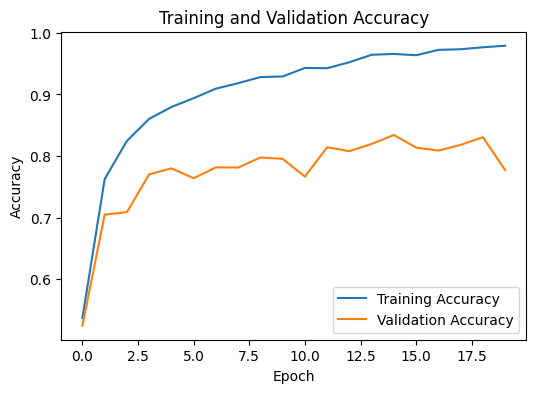

In [14]:




# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



98/98 [==============================] - 8s 82ms/step


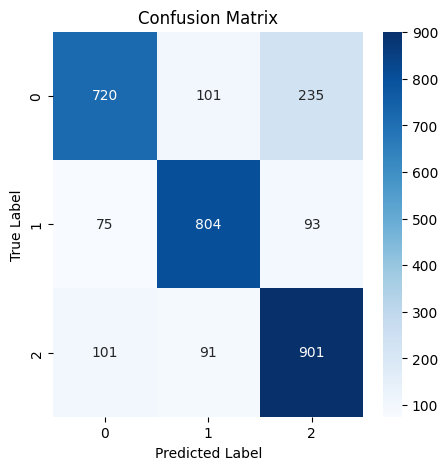

              precision    recall  f1-score   support

      barswa       0.80      0.68      0.74      1056
      comsan       0.81      0.83      0.82       972
     eaywag1       0.73      0.82      0.78      1093

    accuracy                           0.78      3121
   macro avg       0.78      0.78      0.78      3121
weighted avg       0.78      0.78      0.78      3121

F1 Score:  0.775853818295791


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Predict the values from the validation dataset
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one hot vectors
y_true = y_val_encoded

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Compute the overall F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("F1 Score: ", f1)
